# Slater Koster Tight Binding

This notebook contains the original Slater Koster model, as well as my position based Hamiltonian-Symmetry. It serves as a comparison between the two, as they are quite similar.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from tight_binding_redweasel.bandstructure import *
from tight_binding_redweasel.symmetry import *
# not finalized libs
from tight_binding_redweasel import hamiltonian_symmetry as hsym
from tight_binding_redweasel import fermi_surface as fs
from tight_binding_redweasel import kpaths
from tight_binding_redweasel import qespresso_interface as qe

# read the data from Bandx.dat from Quantum Espresso
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands_orig, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))

k_smpl, ref_bands_orig = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands_orig)

ref_bands = ref_bands_orig[:,8:] # 12

# read the data from Bandx.dat from Quantum Espresso
material2 = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl2, _, ref_bands2, symmetries2, fermi_energy2 = material2.read_bands()
k_smpl2, ref_bands2 = Symmetry(symmetries).realize_symmetric_data(k_smpl2, ref_bands2)

Symmetries: 48


neighbors: 14
model sym: 1
loss: 1.32e-01 (max band-error [0.025 0.011 0.009 0.003 0.101 0.082 0.065 0.134 0.146 0.182 0.246 0.155
 0.179 0.163 0.14  0.198 0.316 0.71 ])


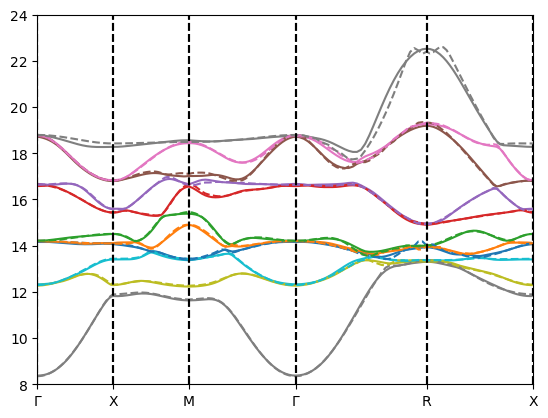

In [2]:
#hsym_nitinol = hsym.HamiltonianSymmetry(Symmetry.cubic(True))
# TODO look at wannier function to find out which energy belongs to which atom
#hsym_nitinol.append_s([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d3([0, 0, 0], "Ni")
#hsym_nitinol.append_d2([0, 0, 0], "Ni")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_p([0, 0, 0], "Ni")

#hsym_nitinol.append_s([0, 0, 0], "Ti")
#hsym_nitinol.append_d2([0, 0, 0], "Ti")
#hsym_nitinol.append_d3([0, 0, 0], "Ni")
#hsym_nitinol.append_d2([0, 0, 0], "Ni")
#hsym_nitinol.append_d3([0, 0, 0], "Ti")
#hsym_nitinol.append_d3([0, 0, 0], "Ni")

#hsym_nitinol.append_s([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ni")
#hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ni")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ni")

ref_bands = ref_bands_orig[:,1:-1] # 18

# now start my algorithm to find good matrices
#add_bands = len(hsym_nitinol) - len(ref_bands[0])
add_bands = 0
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[-4] = 3
weights[-5] = 3
weights[-1] = 0.1

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)


#tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, add_bands, cos_reduced=False, exp=True)
#tb_nitinol.symmetrizer = hsym_nitinol.symmetrizer(neighbors) # for this: cos_reduced=False, exp=True
#tb_nitinol = BandStructureModel.load("ni_asym.repr")
tb_nitinol = BandStructureModel.load("ni_asym_18.json")
print("neighbors:", len(tb_nitinol.params))
print("model sym:", len(tb_nitinol.sym))
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 5, 1, train_k0=True, max_accel_global=1.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 50, 1, train_k0=True, max_accel_global=64.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4, train_k0=True, regularization=0.999)

tb_nitinol.print_error(k_smpl, ref_bands, weights, band_offset)

#k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

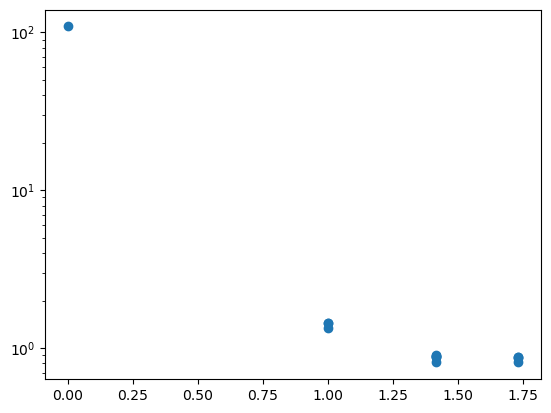

In [3]:
#tb_nitinol.print_model_norms()
norms1 = np.array([(np.linalg.norm(n), np.linalg.norm(p)) for n, p in zip(tb_nitinol.neighbors, tb_nitinol.params)])
plt.semilogy(norms1[:,0], norms1[:,1], 'o')
plt.show()

In [45]:
#tb_nitinol.save("ni_asym_18.json")

final loss: 3.04e-01 (max band-error [0.166 0.411 0.248 0.322 0.507 0.378 0.332 0.41  0.382 0.309 0.874 0.902])


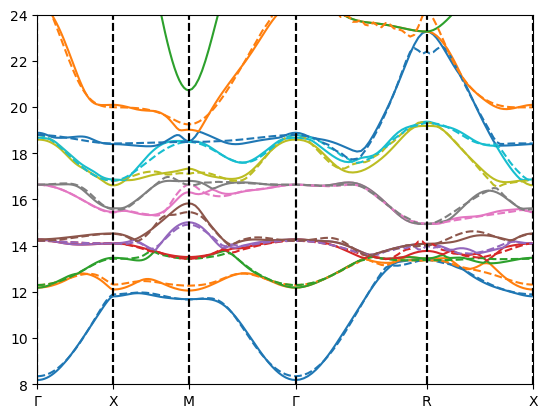

In [10]:
#band_weights = np.exp(-np.mean(ref_bands - fermi_energy, axis=0)**2/2 / 3.0**2)
#band_weights[12:] *= 0.1
tb_nitinol = BandStructureModel.load("sym_nitinol13.json")
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 0, 2)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

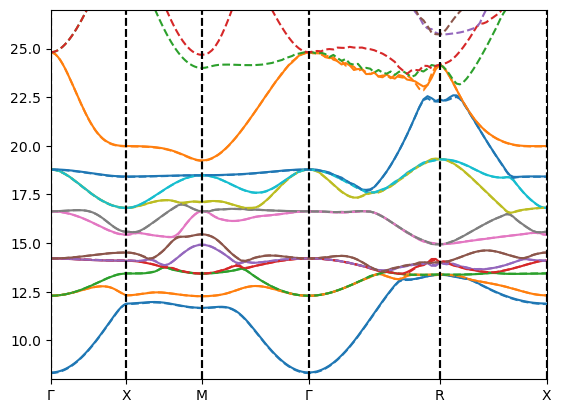

In [4]:
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
interpolator2 = kpaths.interpolate(k_smpl2, ref_bands2[:,8:], Symmetry.none(), method='cubic')
path.plot(interpolator, '-')
path.plot(interpolator2, '--')
plt.ylim(8, 27)
plt.show()

band weights: [0.511 0.696 0.779 0.828 0.869 0.908 0.996 1.    0.961 0.89  0.785 0.472
 0.008 0.003 0.    0.   ]
loss: 2.02e-01 (max band-error [ 0.321  0.157  0.111  0.133  0.127  0.131  0.164  0.121  0.159  0.2
  0.632  0.899  2.604  3.386  7.494 13.15 ])
16.138136727629465


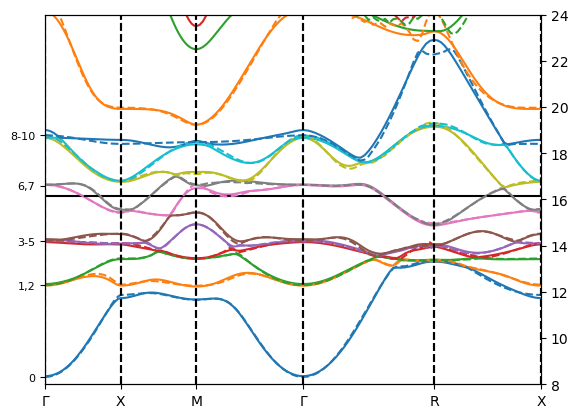

In [8]:
from tight_binding_redweasel import density_of_states as dos

#tb_nitinol = BandStructureModel.load("bruinsma_niti.json")
#tb_nitinol.params[0] += np.eye(len(tb_nitinol.params[0])) * 7.1

tb_nitinol = BandStructureModel.load("bruinsma_improved.json")

band_weights = np.exp(-np.mean(ref_bands2[:,8:] - fermi_energy2, axis=0)**2/2 / 4.0**2)
band_weights[12:] *= 0.1
print("band weights:", band_weights)
tb_nitinol.print_error(k_smpl2, ref_bands2[:,8:], band_weights, 0)
#tb_nitinol.randomize(0.01, keep_zeros=True)
#tb_nitinol.optimize(k_smpl2, 1, ref_bands2[:,8:], band_weights, 0, 100, 1, max_accel_global=4.0, use_pinv=True, keep_zeros=True)

dos_nitinol = dos.DensityOfStates(tb_nitinol, N=20, ranges=((-0.5, 0.5),)*3, wrap=True)
fermi_energy = dos_nitinol.fermi_energy(7)
print(fermi_energy)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
#interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
interpolator2 = kpaths.interpolate(k_smpl2, ref_bands2[:,8:], Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
#path.plot(interpolator, '--')
path.plot(interpolator2, '--', label_bands="left", ylim=(8, 24))
plt.axhline(fermi_energy, color='k')
#plt.savefig("bruinsma_comparison.pdf")
#plt.savefig("bruinsma_improved_comparison.pdf")
plt.show()

In [14]:
# test symmetry:
Symmetry.cubic(True).check_symmetry(tb_nitinol) # not fulfilled


symmetry error
[0.014 0.025 0.026 0.021 0.008 0.017 0.019 0.018 0.014 0.014 0.014 0.089
 0.131 0.117 0.088 0.258 0.55  0.269]


False

In [13]:
#tb_nitinol.save("bruinsma_improved.json")

In [8]:
# for saving the fermi surface plots using: show=save
def save():
    plt.savefig(f"{np.random.randint(0, 100)}.pdf")
    plt.close()

In [13]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

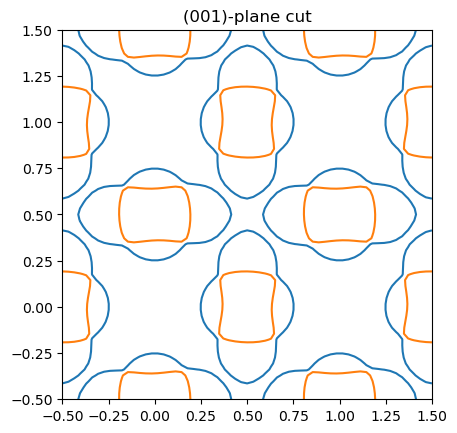

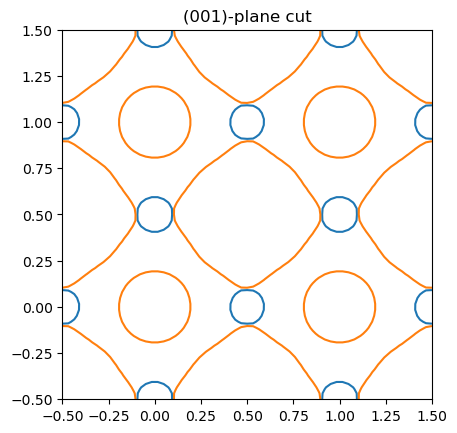

In [10]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63, k_range=[-0.5, 1.5])

In [9]:
fs.plot_2D_fermi_surface(interpolator2, fermi_energy, N=63, show=save)

In [9]:
import importlib
importlib.reload(fs)
#fs.plot_3D_fermi_surface(interpolator2, fermi_energy)
#fs.export_3D_fermi_surface("DFT_niti_fermi_surface", interpolator2, fermi_energy)
#fs.export_3D_fermi_surface("bruinsma_fermi_surface", tb_nitinol, fermi_energy)
fs.export_3D_fermi_surface("bruinsma_improved_fermi_surface", tb_nitinol, fermi_energy)

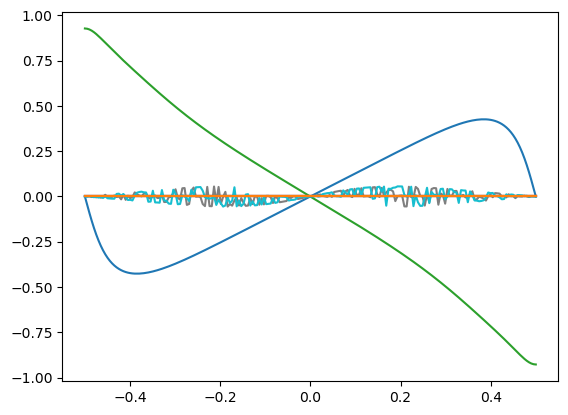

In [15]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

In [16]:
np.set_printoptions(precision=2, linewidth=1000)
# compute the inversion symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, 1e-4]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, -1e-4]))[1]
print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
print(Uk1)

[-1.-0.08j -1.+0.08j -1.-0.j   -1.+0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.+0.j  ]
[[ 0.99+0.j  0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  -0.j -0.  +0.j -0.12+0.j]
 [-0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.03+0.j -1.  +0.j -0.  +0.j -0.  +0.j  0.01+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j  1.  +0.j -0.03+0.j  0.  +0.j -0.01+0.j -0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -1.  +0.j -0.  +0.j  0.  +0.j -0.01+0.j -0.  +0.j -0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j  0.96+0.j  0.  +0.j -0.  +0.j  0. 

# Wannier90 Models

neighbors: 365
model sym: 1
loss: 3.18e-01 (max band-error [20.636  0.126  0.369  0.004  0.128  0.19   0.181  0.689  0.345  0.085
  0.197  0.356  0.363  0.433  0.43   0.403  0.342  2.454])


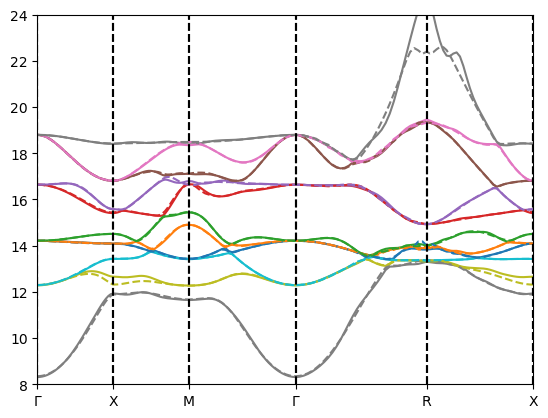

In [4]:
#ref_bands = ref_bands[:,8:-1] # 11
ref_bands = ref_bands_orig[:,1:-1] # 18

band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[-1] = 1.0

tb_nitinol = BandStructureModel.load("niti_18_wd_hr.dat")
print("neighbors:", len(tb_nitinol.params))
print("model sym:", len(tb_nitinol.sym))

weights[0] = 0.0
tb_nitinol.print_error(k_smpl, ref_bands, weights, band_offset)

#k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

[12.421  2.391]


/tmp/ipykernel_196796/120751393.py:6: RuntimeWarning: divide by zero encountered in power
  return a*x**-b


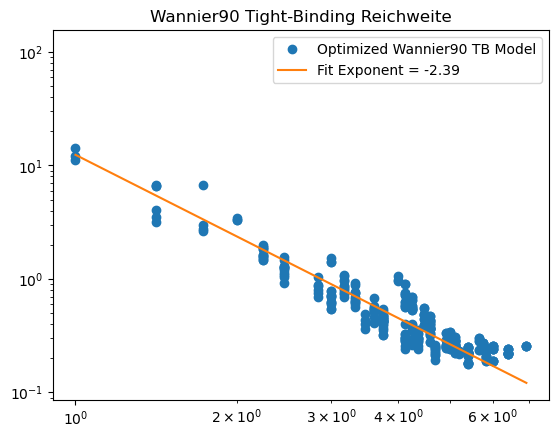

In [19]:
norms2 = np.array([(np.linalg.norm(n), np.linalg.norm(p)) for n, p in zip(tb_nitinol.neighbors, tb_nitinol.params)])

from scipy.optimize import curve_fit as fit

def linear_fit(x, a, b):
    return a*x**-b
popt, pcov = fit(linear_fit, norms2[norms2[:,0] != 0,0], norms2[norms2[:,0] != 0,1])
print(popt)
plt.title("Wannier90 Tight-Binding Reichweite")
plt.loglog(norms2[:,0], norms2[:,1], 'o', label="Optimized Wannier90 TB Model")
plt.loglog(norms2[:,0], linear_fit(norms2[:,0], *popt), label=f"Fit Exponent = {-popt[-1]:.2f}")
plt.legend()
plt.savefig("wannier90_tb_matrix_decay.png")
plt.show()

In [6]:
# file:
orbitals = ["3s", "3p_x", "3p_y", "3p_z", "3d_zy", "3d_zx", "3d_xy", "3d_{z^2}", "3d_{x^2-y^2}"]#, "4s"]
orbitals = ["Ni " + x for x in orbitals] + ["Ti " + x for x in orbitals]

hsym_atomic = hsym.HamiltonianSymmetry(Symmetry.cubic(True))
hsym_atomic.append_s([0, 0, 0], "Ni") # s
hsym_atomic.append_p([0, 0, 0], "Ni") # p_x p_y p_z
hsym_atomic.append_d3([0, 0, 0], "Ni") # d_zy d_zx d_xy
hsym_atomic.append_d2([0, 0, 0], "Ni") # d_{z^2} d_{x^2-y^2}
hsym_atomic.append_s([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_p([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_d3([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_d2([0.5, 0.5, 0.5], "Ti")
# both for p and for d orbitals, some reordering is necessary
atomic_order = [0, 1+1, 1+2, 1+0, 4+2, 4+1, 4+4, 4+0, 4+3]
atomic_order = atomic_order + [x + 9 for x in atomic_order]

symmetrizer = hsym_atomic.symmetrizer(tb_nitinol.neighbors)

neighbors: 365
model sym: 1


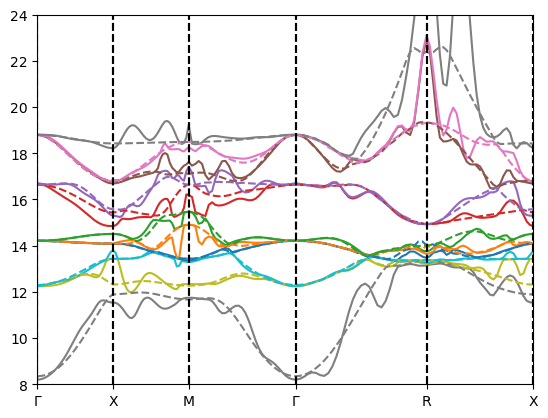

In [7]:
tb_nitinol = BandStructureModel.load("niti_18_de_hr.dat")
inv_atomic_order = np.zeros_like(atomic_order)
inv_atomic_order[atomic_order] = np.arange(len(atomic_order))
tb_nitinol.permute(atomic_order)
print("neighbors:", len(tb_nitinol.params))
print("model sym:", len(tb_nitinol.sym))

#print(tb_nitinol.f([0,0,0]))

#tb_nitinol.symmetrizer = symmetrizer
#tb_nitinol.normalize()

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

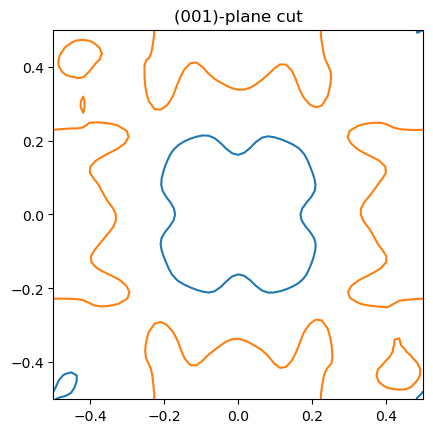

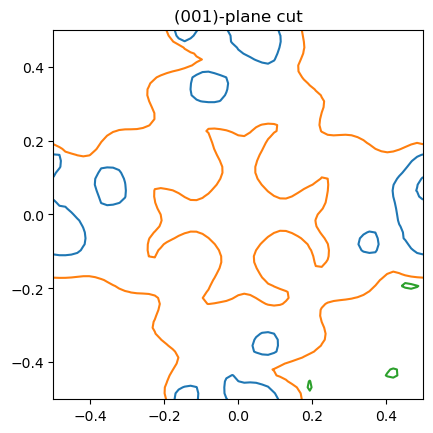

In [8]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63, k_range=[-0.5, 0.5])

[ 0.83-0.56j  0.88+0.47j  0.95-0.3j   1.  +0.j    1.  +0.j    1.  +0.j   -0.5 +0.87j -0.57-0.82j -0.63-0.78j -0.87+0.5j  -0.98-0.19j -0.98+0.18j -0.98+0.18j -1.  +0.05j -1.  +0.01j -1.  -0.01j -1.  -0.06j -1.  +0.j  ]
[[ 1.  +0.j   -0.  +0.j   -0.  -0.j   -0.  +0.j   -0.  -0.j    0.  -0.j    0.  +0.j    0.  -0.j   -0.  +0.j    0.  -0.j    0.02-0.j    0.01-0.j    0.01+0.j    0.  +0.j   -0.  +0.j   -0.  -0.j   -0.  +0.j    0.  -0.j  ]
 [-0.  +0.j    0.77-0.2j   0.27+0.44j  0.25-0.2j  -0.  -0.j    0.  -0.j   -0.  +0.j   -0.  +0.j    0.  -0.j    0.  -0.j    0.06-0.j    0.02+0.01j  0.01-0.j    0.  +0.j   -0.  +0.j    0.  -0.j    0.  -0.j   -0.  +0.j  ]
 [-0.  -0.j    0.34+0.11j  0.42-0.51j  0.03+0.66j -0.  -0.j    0.  +0.j    0.  +0.j   -0.  +0.j    0.  -0.j   -0.  +0.j    0.02+0.j    0.04-0.01j  0.01+0.02j  0.  +0.j   -0.  -0.j   -0.  -0.j    0.  -0.j   -0.  -0.j  ]
 [-0.  +0.j    0.12+0.48j  0.25-0.49j  0.08-0.67j  0.  -0.j    0.  +0.j   -0.  +0.j   -0.  +0.j    0.  -0.j    0.  +0.j    0.

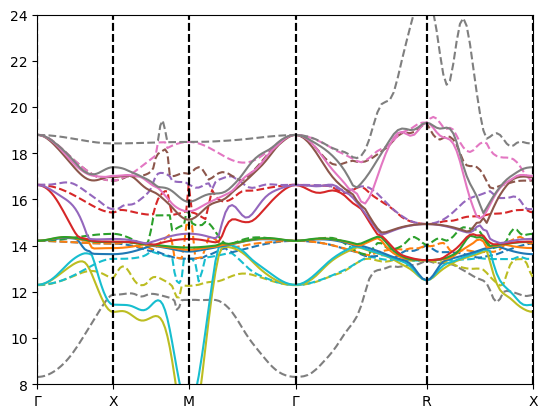

In [30]:
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
#interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')

tb_nitinol2 = BandStructureModel.load("niti_18_de.json")
path.plot(tb_nitinol2, '--')
inv_atomic_order = np.zeros_like(atomic_order)
inv_atomic_order[atomic_order] = np.arange(len(atomic_order))
tb_nitinol2.permute(atomic_order)

np.set_printoptions(precision=2, linewidth=1000)
# compute the inversion symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol2.f([1e-4, 2e-4, 3e-4]))[1]
Uk2 = np.linalg.eigh(tb_nitinol2.f([1e-4, 3e-4, -2e-4]))[1]
print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
print(Uk1 @ np.conj(Uk2.T))

#print(tb_nitinol2.f([0,0,0]))

tb_nitinol2.symmetrizer = symmetrizer
tb_nitinol2.normalize()

path.plot(tb_nitinol2, '-')
#path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [19]:
np.set_printoptions(precision=2, linewidth=1000)
# compute the inversion symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, 1e-3]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, -1e-3]))[1]
print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
print(np.round(Uk1 @ np.conj(Uk2.T), 1))

[-0.99+0.16j -1.  -0.j   -1.  +0.07j -1.  +0.04j -1.  +0.05j  0.79+0.62j  0.98-0.19j  1.  +0.09j  1.  +0.09j  0.99-0.1j   1.  -0.08j  1.  -0.06j  1.  -0.04j  1.  -0.02j  1.  +0.01j  1.  -0.j    1.  +0.j    1.  +0.j  ]
[[ 1. +0.j  -0. -0.j   0. -0.j  -0. +0.j  -0. -0.j  -0. +0.j   0. -0.j  -0. -0.j   0. +0.j   0. -0.j   0. +0.j  -0. -0.j  -0. +0.j  -0. +0.j  -0. -0.j   0. +0.j   0. +0.j  -0. -0.j ]
 [-0. +0.j   1. -0.1j -0. +0.1j  0. +0.j  -0. -0.j  -0. -0.j  -0. -0.j  -0. -0.j   0. -0.j  -0. -0.j   0. +0.j  -0. -0.j  -0. +0.j  -0. +0.j  -0. +0.j   0. +0.j   0. -0.j  -0. -0.j ]
 [ 0. -0.j   0. +0.1j  1. -0.j   0. -0.3j -0. -0.j  -0. -0.j   0. +0.j  -0. +0.j   0. +0.j   0. +0.j  -0. +0.j   0. -0.j  -0. -0.j   0. +0.j  -0. -0.j   0. +0.j   0. -0.j  -0. -0.j ]
 [-0. +0.j  -0. +0.j   0.1-0.2j  0.8+0.5j  0. +0.j   0. -0.j  -0. -0.j   0. -0.j   0. -0.j  -0. +0.j  -0. -0.j   0. -0.j   0. +0.j   0. +0.j   0. +0.j  -0. -0.j   0. +0.j  -0. +0.j ]
 [-0. +0.j  -0. +0.j  -0. -0.j   0. -0.j   1. -0.j

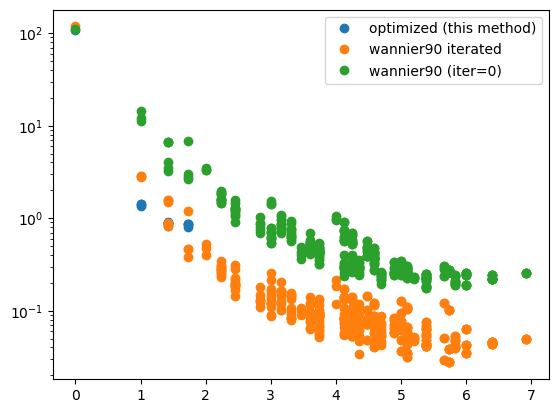

In [8]:
norms3 = np.array([(np.linalg.norm(n), np.linalg.norm(p)) for n, p in zip(tb_nitinol.neighbors, tb_nitinol.params)])
plt.semilogy(norms1[:,0], norms1[:,1], 'o', label="optimized (this method)")
plt.semilogy(norms2[:,0], norms2[:,1], 'o', label="wannier90 iterated")
plt.semilogy(norms3[:,0], norms3[:,1], 'o', label="wannier90 (iter=0)")
plt.legend()
plt.show()

# Alternative Model with s-Orbitals

In [ ]:
# read the data from Bandx.dat from Quantum Espresso
from tight_binding_redweasel import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_bands = material.read_bandx_raw()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
neutral_electrons = 7

# now start my algorithm to find good matrices
add_bands = 0
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.005
weights[1] = 0.005
weights[2] = 0.05
weights[3] = 0.5
weights[-1] = 0.005
weights[-2] = 0.05
weights[-3] = 0.5

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (2, 2, 2), (3, 0, 0)) # works well
tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.cubic(True), neighbors, k_smpl, ref_bands, band_offset, add_bands)
tb_nitinol.normalize()
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4)

# TODO check why this still works but the other code needs a learning rate < 1

#plot_bands_generic(k_smpl, ref_bands, '.')
#tb_nitinol.plot_bands(k_smpl)